In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize

In [ ]:
file_path = '/content/drive/My Drive/IDC/Year 3/Final Project/fetal_health.csv'
data = pd.read_csv(file_path)

# Step 1: Develop baseline with raw data

In [ ]:
# Splitting the data into features and target variable
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

# Stratified split of the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Binarizing the test and validation labels
y_test_binarized = label_binarize(y_test, classes=[1, 2, 3])
y_val_binarized = label_binarize(y_val, classes=[1, 2, 3])

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Checking the splits
print(f'Training set size: {X_train.shape[0]}')
print(f'Validation set size: {X_val.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')

Training set size: 1488
Validation set size: 319
Test set size: 319


In [ ]:
class_mapping = {1: "normal", 2: "suspect", 3: "pathological"}

In [ ]:
results_path = '/content/drive/My Drive/IDC/Year 3/Final Project/models_results.csv'
df = pd.DataFrame(columns=['Model Name', 'Overall Acc', 'Class Normal Acc', 'Class Suspect Acc', 'Class Patho Acc', 'Class Normal AUC', 'Class Suspect AUC', 'Class Patho AUC'])
df.to_csv(results_path, index=False)

In [ ]:
def evaluate_model_and_update_csv(y_pred, y_pred_proba, model_name):
    # Confusion Matrix and Visualization
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Model Accuracy and Per-Class Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    print(f"Accuracy of {model_name}: {accuracy * 100:.2f}%\n")
    for i, acc in enumerate(per_class_accuracy):
        class_name = class_mapping[i + 1]  # Assuming class_mapping starts at 1
        print(f"Accuracy for {class_name}: {acc * 100:.2f}%")

    # AUC Calculation
    n_classes = len(np.unique(y_test))  # Assuming y_test contains all classes
    roc_auc_dict = {}
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i + 1] = auc(fpr, tpr)

    # Print AUC scores
    print("\nAUC Scores:")
    for class_id in class_mapping:
        if class_id in roc_auc_dict:
            print(f"AUC for class '{class_mapping[class_id]}': {roc_auc_dict[class_id]:.2f}")

    # Store results in a dictionary
    results = {
        'Model Name': model_name,
        'Overall Acc': round(accuracy * 100, 2),
        'Class Normal Acc': round(per_class_accuracy[0] * 100, 2),
        'Class Suspect Acc': round(per_class_accuracy[1] * 100, 2),
        'Class Patho Acc': round(per_class_accuracy[2] * 100, 2),
        'Class Normal AUC': round(roc_auc_dict[1], 2),
        'Class Suspect AUC': round(roc_auc_dict[2], 2),
        'Class Patho AUC': round(roc_auc_dict[3], 2)
    }

    df_existing = pd.read_csv(results_path)
    df_updated = pd.concat([df_existing, pd.DataFrame([results])], ignore_index=True)
    df_updated.to_csv(results_path, index=False)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc

def evaluate_model_with_visualization(y_pred, y_pred_proba, model_name, y_test, class_mapping, y_test_binarized):
    # Confusion Matrix and Calculation
    cm = confusion_matrix(y_test, y_pred)
    per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
    overall_accuracy = accuracy_score(y_test, y_pred)

    # AUC Calculation
    n_classes = len(np.unique(y_test))
    roc_auc_dict = {}
    fpr_dict, tpr_dict = {}, {}
    for i in range(n_classes):
        fpr_dict[i + 1], tpr_dict[i + 1], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i + 1] = auc(fpr_dict[i + 1], tpr_dict[i + 1])

    # Plot 1: Confusion Matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt='g',
                xticklabels=["normal", "suspect", "pathological"],
                yticklabels=["normal", "suspect", "pathological"])
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Plot 2: ROC/AUC Curve
    plt.figure(figsize=(6, 6))
    for i in range(n_classes):
        plt.plot(fpr_dict[i + 1], tpr_dict[i + 1], label=f'{class_mapping[i + 1]} (AUC = {roc_auc_dict[i + 1]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC/AUC Curve')
    plt.legend(loc='lower right')
    plt.show()

    # Plot 3: Accuracy Table with Overall Accuracy
    plt.figure(figsize=(4, 2))
    plt.axis('off')
    accuracy_data = {
        'Class': [class_mapping[1], class_mapping[2], class_mapping[3], 'Overall'],
        'Accuracy': [f"{per_class_accuracy[0] * 100:.2f}%",
                     f"{per_class_accuracy[1] * 100:.2f}%",
                     f"{per_class_accuracy[2] * 100:.2f}%",
                     f"{overall_accuracy * 100:.2f}%"]
    }
    accuracy_df = pd.DataFrame(accuracy_data)
    tbl = plt.table(cellText=accuracy_df.values, colLabels=accuracy_df.columns, cellLoc='center', loc='center')
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(10)
    tbl.scale(1, 1.5)
    plt.title(f'{model_name} Accuracy Table')
    plt.show()

# Example usage:
# evaluate_model_with_visualization(y_pred, y_pred_proba, "Plain LR", y_test, class_mapping, y_test_binarized)


## Logistic Regression

* Statistical model to predict the prob of an outcome, based on one of more predictor features
* Predicts the prob that a given input points belongs to a certain points
* Uses logistic regression (sigmoid) to model the probability    
*  Modeled as a logistic function of a linear combination of input features
* Limitations: assumes linearity between dependent variables and independent variables   


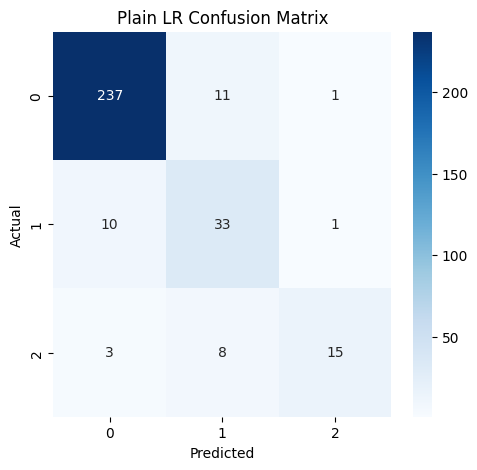

Accuracy of Plain LR: 89.34%

Accuracy for normal: 95.18%
Accuracy for suspect: 75.00%
Accuracy for pathological: 57.69%

AUC Scores:
AUC for class 'normal': 0.98
AUC for class 'suspect': 0.93
AUC for class 'pathological': 0.98


In [ ]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)  # Get prediction probabilities

evaluate_model_and_update_csv(
    y_pred=y_pred,
    y_pred_proba=y_pred_proba,
    model_name='Plain LR'
)

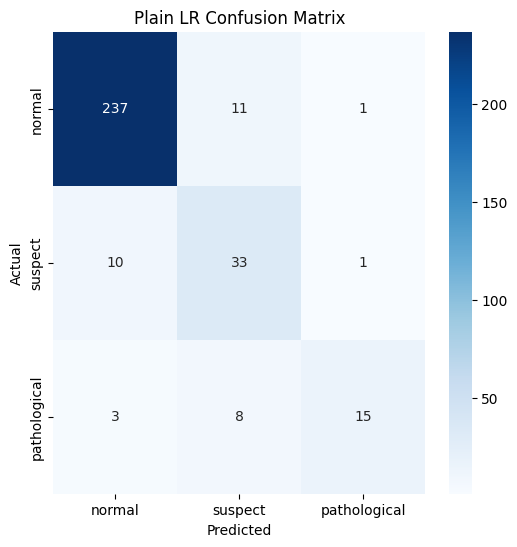

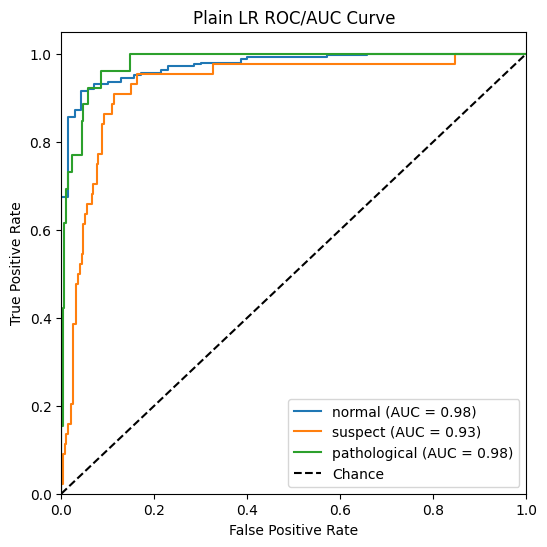

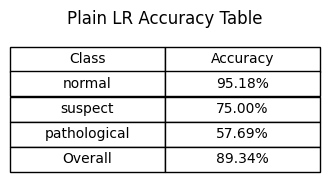

In [ ]:
evaluate_model_with_visualization(y_pred, y_pred_proba, "Plain LR", y_test, class_mapping, y_test_binarized)

* The model is highly accurate in predicting the 'normal' class with an accuracy of 94.58%, and an exceptional AUC of 0.97

* The accuracies for 'suspect' and 'pathological' classes are moderate, at 67.80% and 65.71%, respectively. However, the AUC scores are notably high (0.93 for 'suspect' and 0.98 for 'pathological'), suggesting that while there are misclassifications, the model has a good ability to rank predictions correctly.

## RFE with Logistic Regression
* RFE is feature selection to identify the most significant features for a predictive model
* Works by recursively removing the least important features: ranks each features by its importance (coefficients)

=== Recursive Feature Elimination (RFE) Results ===

Number of Features Selected: 10

Selected Features:
['baseline value', 'accelerations', 'uterine_contractions', 'prolongued_decelerations', 'abnormal_short_term_variability', 'percentage_of_time_with_abnormal_long_term_variability', 'histogram_mode', 'histogram_mean', 'histogram_median', 'histogram_variance']

Feature Ranking (1 indicates selected):
[ 1  1  4  1 11  9  1  1  6  1  8 12  7  3  2  5  1  1  1  1 10]


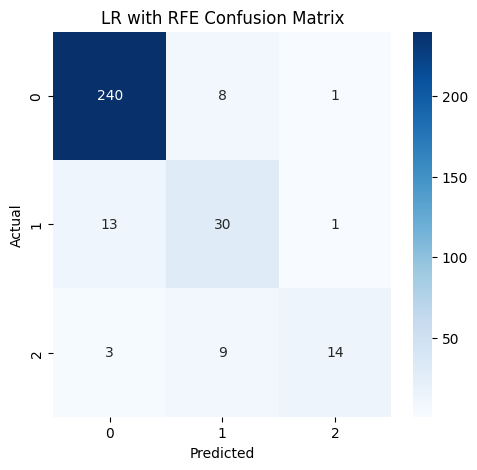

Accuracy of LR with RFE: 89.03%

Accuracy for normal: 96.39%
Accuracy for suspect: 68.18%
Accuracy for pathological: 53.85%

AUC Scores:
AUC for class 'normal': 0.97
AUC for class 'suspect': 0.92
AUC for class 'pathological': 0.98


In [ ]:
model_rfe = LogisticRegression(max_iter=1000)
rfe = RFE(estimator=model_rfe, n_features_to_select=None)  # n_features_to_select=None means half will be selected
rfe = rfe.fit(X_train_scaled, y_train)

X_train_rfe = rfe.transform(X_train_scaled)
X_test_rfe = rfe.transform(X_test_scaled)

model_rfe.fit(X_train_rfe, y_train)

y_pred_rfe = model_rfe.predict(X_test_rfe)
y_pred_proba_rfe = model_rfe.predict_proba(X_test_rfe)

print("=== Recursive Feature Elimination (RFE) Results ===")
print("\nNumber of Features Selected: {}".format(rfe.n_features_))
print("\nSelected Features:")
print(X.columns[rfe.support_].tolist())
print("\nFeature Ranking (1 indicates selected):")
print(rfe.ranking_)

evaluate_model_and_update_csv(
    y_pred=y_pred_rfe,
    y_pred_proba=y_pred_proba_rfe,
    model_name='LR with RFE'
)

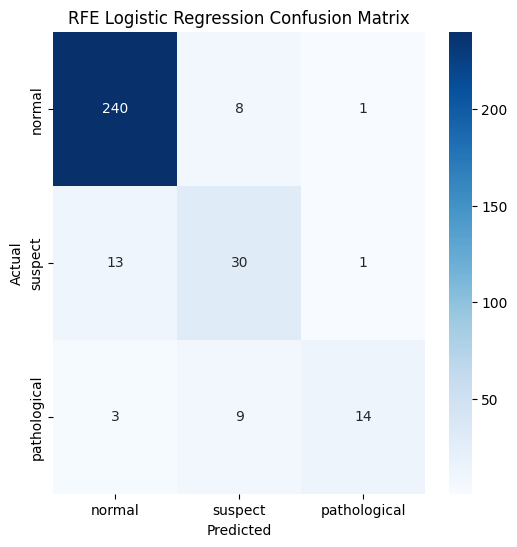

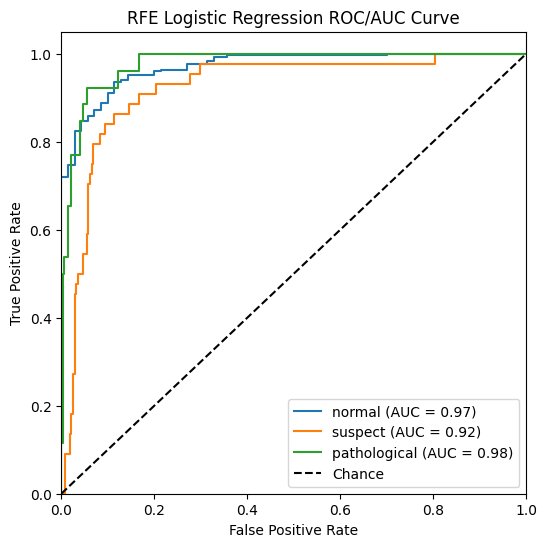

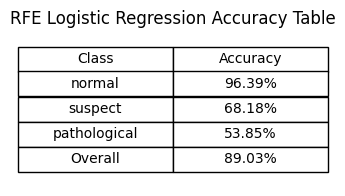

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_pred_rfe,
    y_pred_proba=y_pred_proba_rfe,
    model_name="RFE Logistic Regression",
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)


*   Improved the classification of 'normal' cases to a high accuracy of 95.48%, while also showing a significant ability to differentiate between all classes with AUC scores above 0.9.

*   The accuracies for 'suspect' and 'pathological' classes are 69.49% and 68.57%

*   With AUC scores of 0.97 for 'normal', 0.93 for 'suspect', and 0.98 for 'pathological', the model demonstrates a strong discriminative ability despite some misclassifications

## Decision Trees

* Non linear, non parametric supervised learning method
* DT splits the data into subsets based on the value of input features   
* Root node represents the entire dataset, which gets divided into 2 or more sets. Splitting will divide a node into 2 or more sub nodes based on certain conditions (called decision nodes)
* Leaf / terminal nodes have no children  
* For classification: prediction is found by traversing the tree

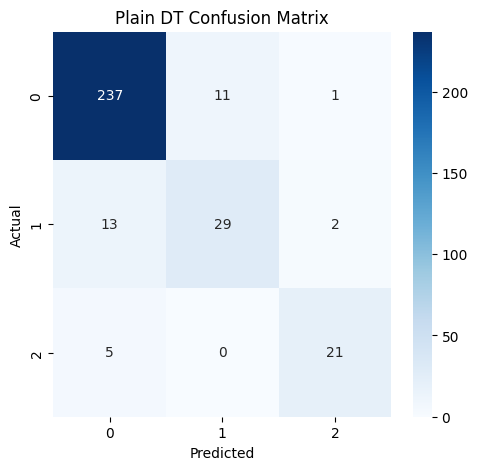

Accuracy of Plain DT: 89.97%

Accuracy for normal: 95.18%
Accuracy for suspect: 65.91%
Accuracy for pathological: 80.77%

AUC Scores:
AUC for class 'normal': 0.85
AUC for class 'suspect': 0.81
AUC for class 'pathological': 0.90


In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)

evaluate_model_and_update_csv(
    y_pred=y_pred_dt,
    y_pred_proba=y_pred_proba_dt,
    model_name='Plain DT'
)

* Model excels at identifying the 'normal' class with high accuracy and a reasonably good AUC
  
* The model shows lower accuracy for 'suspect' cases and a moderate ability to distinguish them as indicated by the AUC

* 'Pathological' cases are identified with better accuracy than 'suspect' cases and the model has a good AUC score for this class, indicating a strong capability in distinguishing more severe cases from less severe ones.

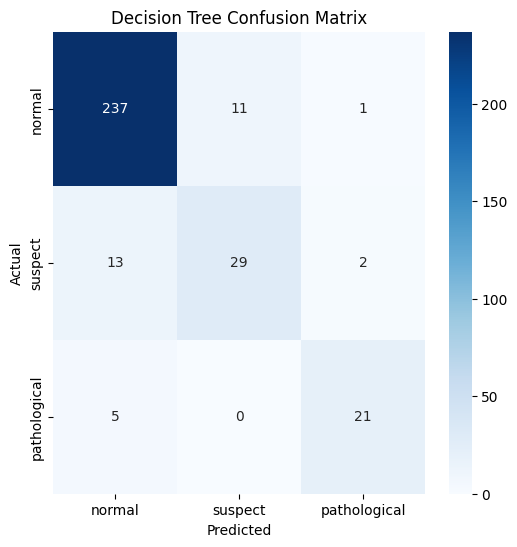

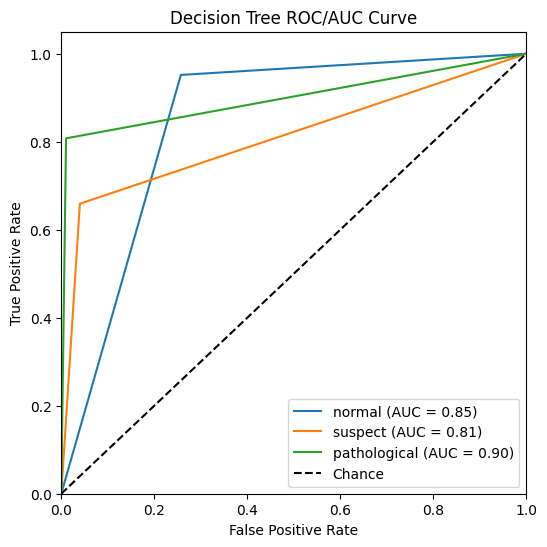

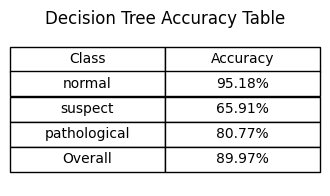

In [ ]:
evaluate_model_with_visualization(y_pred_dt, y_pred_proba_dt, "Decision Tree", y_test, class_mapping, y_test_binarized)

Baseline Model Takeaways:

* DTs product higher overall accuracy compared to LR (even with feature selection)
  * DTs are non linear models that can handle more complex relationships (LR assumes linear relationship)
  * DTs capture interactions between different features without need for explicit feature engineering

# Step 2: Handle class imbalance

In [ ]:
fetal_health_counts = data['fetal_health'].value_counts()
fetal_health_counts

,count
fetal_health,
1.0,1655
2.0,295
3.0,176


## SMOTE

* Synthetic Minority OVer sampling technique
* Statistical technique for increasing the number of samples
* Calculates the k nearest neighbors: selects neighbors and generates new points at a chosen distance between the original sample and its neighbors

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

additional_percentage = 0.015
additional_samples_class_2 = int(fetal_health_counts[2] * additional_percentage)
additional_samples_class_3 = int(fetal_health_counts[3] * additional_percentage)

# Define the sampling strategy: no new samples for class 1, 1.5% more for classes 2 and 3
sampling_strategy = {
    2: fetal_health_counts[2] + additional_samples_class_2,
    3: fetal_health_counts[3] + additional_samples_class_3
}

# Initialize and apply SMOTE only on TRAIN data
smote = SMOTE(sampling_strategy=sampling_strategy)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

resampled_train_data = pd.DataFrame(X_train_resampled, columns=X.columns)
resampled_train_data['fetal_health'] = y_train_resampled
resampled_train_data = shuffle(resampled_train_data)
resampled_train_data.reset_index(drop=True, inplace=True)

In [ ]:
fetal_health_counts = resampled_train_data['fetal_health'].value_counts()
fetal_health_counts

,count
fetal_health,
1.0,1158
2.0,299
3.0,178


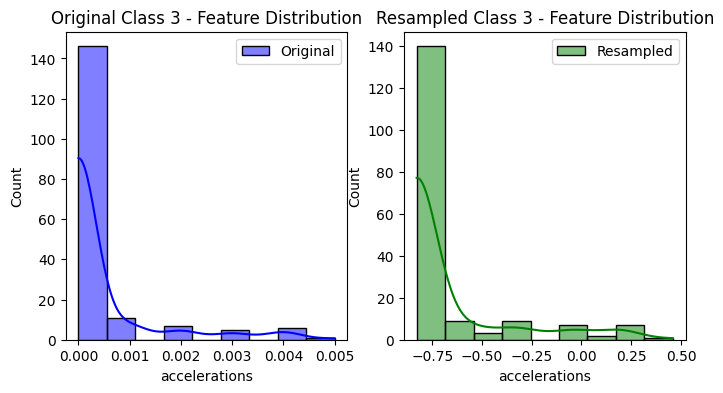

In [ ]:
feature = 'accelerations'
#baseline value	accelerations	fetal_movement	uterine_contractions

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
sns.histplot(data[data['fetal_health'] == 3.0][feature], kde=True, color='blue', label='Original')
plt.title('Original Class 3 - Feature Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(resampled_train_data[resampled_train_data['fetal_health']== 3.0][feature], kde=True, color='green', label='Resampled')
plt.title('Resampled Class 3 - Feature Distribution')
plt.legend()

plt.show()

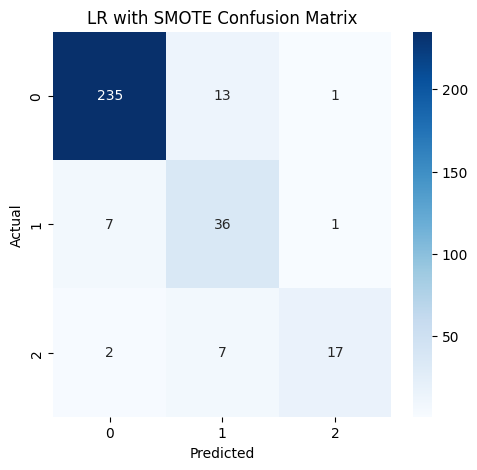

Accuracy of LR with SMOTE: 90.28%

Accuracy for normal: 94.38%
Accuracy for suspect: 81.82%
Accuracy for pathological: 65.38%

AUC Scores:
AUC for class 'normal': 0.98
AUC for class 'suspect': 0.93
AUC for class 'pathological': 0.98


In [ ]:
# LR
new_lr_model = LogisticRegression(max_iter=1000)
new_lr_model.fit(X_train_resampled, y_train_resampled)

y_pred_lrsmote = new_lr_model.predict(X_test_scaled)
y_pred_proba_lrsmote = new_lr_model.predict_proba(X_test_scaled)  # Get prediction probabilities

evaluate_model_and_update_csv(
    y_pred=y_pred_lrsmote,
    y_pred_proba=y_pred_proba_lrsmote,
    model_name='LR with SMOTE'
)

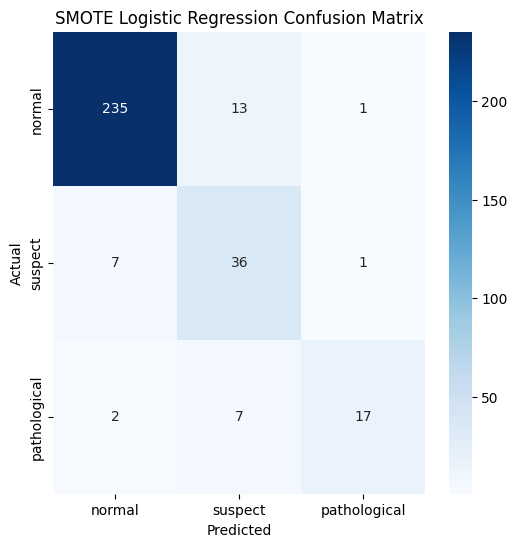

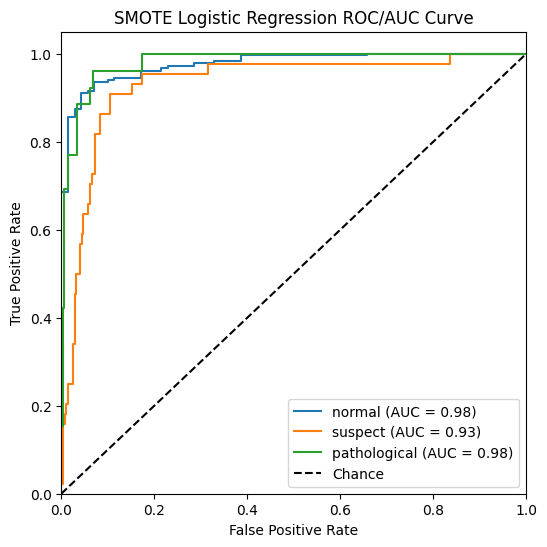

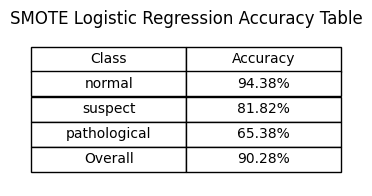

In [ ]:
evaluate_model_with_visualization(
    y_pred_lrsmote,
    y_pred_proba_lrsmote,
    "SMOTE Logistic Regression",
    y_test,
    class_mapping,
    y_test_binarized
)


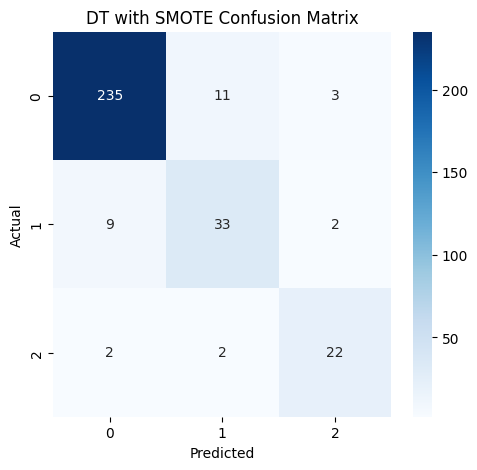

Accuracy of DT with SMOTE: 90.91%

Accuracy for normal: 94.38%
Accuracy for suspect: 75.00%
Accuracy for pathological: 84.62%

AUC Scores:
AUC for class 'normal': 0.89
AUC for class 'suspect': 0.85
AUC for class 'pathological': 0.91


In [ ]:
# DTs

new_dt_model = DecisionTreeClassifier(random_state=42)
new_dt_model.fit(X_train_resampled, y_train_resampled)

y_pred_dtsmote = new_dt_model.predict(X_test_scaled)
y_pred_proba_dtsmote = new_dt_model.predict_proba(X_test_scaled)

evaluate_model_and_update_csv(
    y_pred=y_pred_dtsmote,
    y_pred_proba=y_pred_proba_dtsmote,
    model_name='DT with SMOTE'
)

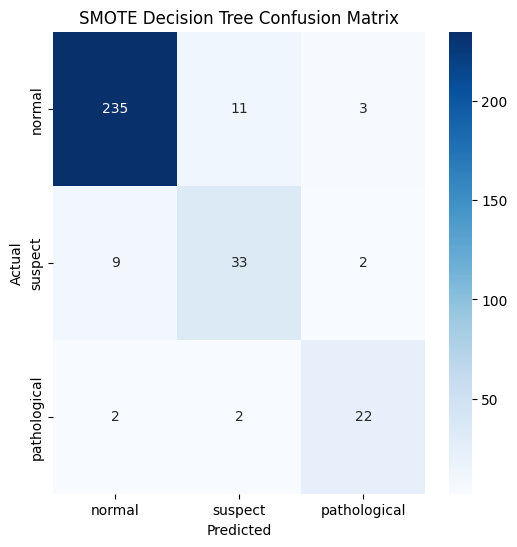

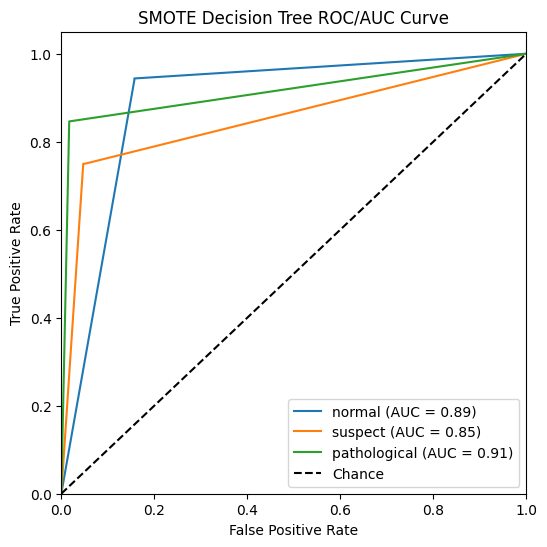

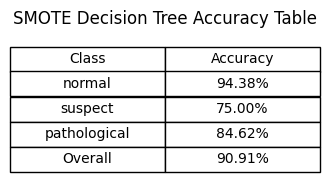

In [ ]:
evaluate_model_with_visualization(
    y_pred=y_pred_dtsmote,
    y_pred_proba=y_pred_proba_dtsmote,
    model_name="SMOTE Decision Tree",
    y_test=y_test,
    class_mapping=class_mapping,
    y_test_binarized=y_test_binarized
)
